In [215]:
import numpy as np
import matplotlib.pyplot as plt
import time

import imagepers

from skimage.filters import threshold_otsu, median, threshold_multiotsu
from scipy.signal import peak_widths, find_peaks
from scipy.ndimage import shift
from scipy.optimize import curve_fit
# https://www.sthu.org/code/codesnippets/imagepers.html

<IPython.core.display.Javascript object>


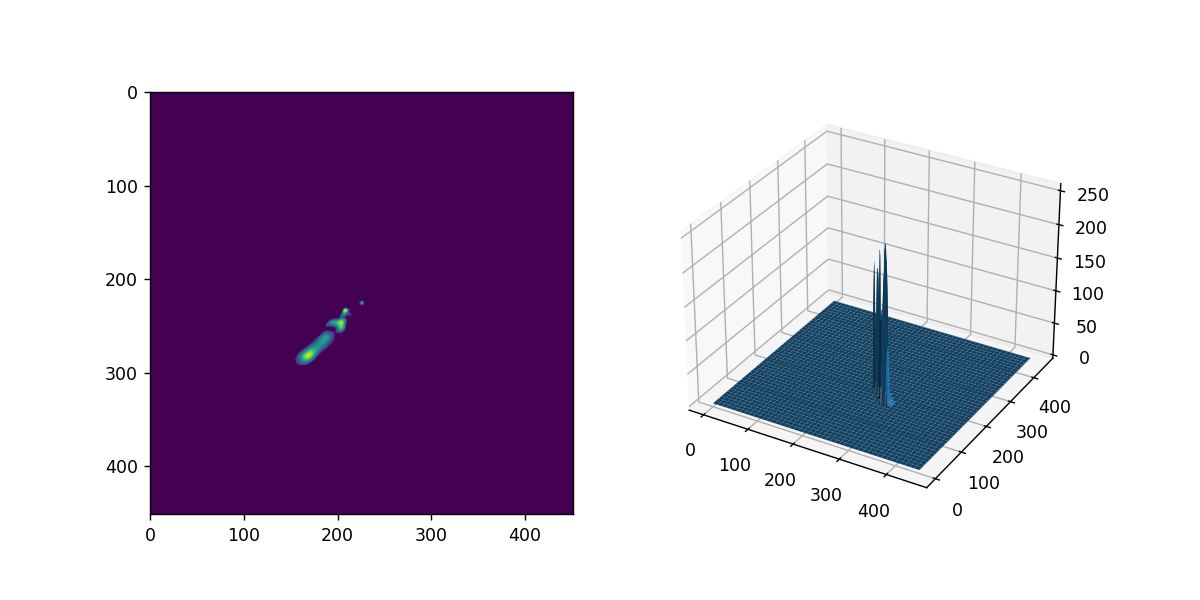

In [2]:
%matplotlib notebook

im = np.loadtxt("D:/astro/domecam/data/20210130l_m2km_corr_4.gz")
im = im* (im > threshold_multiotsu(im)[0])
im = median(im)
im = im * (255 / np.max(im))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(im)

ax = fig.add_subplot(1, 2, 2, projection='3d')
xx, yy = np.mgrid[0:im.shape[0], 0:im.shape[1]]
ax.plot_surface(xx, yy, im, rstride=10, cstride=10)
plt.show()

In [3]:
g0 = imagepers.persistence(im)
g0

[((234, 208), 255.0, 255.0, None),
 ((281, 169), 238.3172799154959, 238.3172799154959, (255, 185)),
 ((226, 226), 173.39126150595996, 173.39126150595996, (230, 207)),
 ((247, 204), 227.02159712463856, 155.98925873391363, (241, 205)),
 ((264, 186), 151.46478439584635, 20.4216548011928, (270, 181)),
 ((0, 0), 0.0, 0.0, (223, 224))]

p_birth: (234, 208), bl (birth lvl): 255.0, pers: 255.0, death lvl: 0.0, p_death: None
p_birth: (281, 169), bl (birth lvl): 238.3172799154959, pers: 238.3172799154959, death lvl: 0.0, p_death: (255, 185)
p_birth: (226, 226), bl (birth lvl): 173.39126150595996, pers: 173.39126150595996, death lvl: 0.0, p_death: (230, 207)
p_birth: (247, 204), bl (birth lvl): 227.02159712463856, pers: 155.98925873391363, death lvl: 71.03233839072493, p_death: (241, 205)
p_birth: (264, 186), bl (birth lvl): 151.46478439584635, pers: 20.4216548011928, death lvl: 131.04312959465355, p_death: (270, 181)
p_birth: (0, 0), bl (birth lvl): 0.0, pers: 0.0, death lvl: 0.0, p_death: (223, 224)
x: [208, 169, 226, 204, 186]
y: [234, 281, 226, 247, 264]


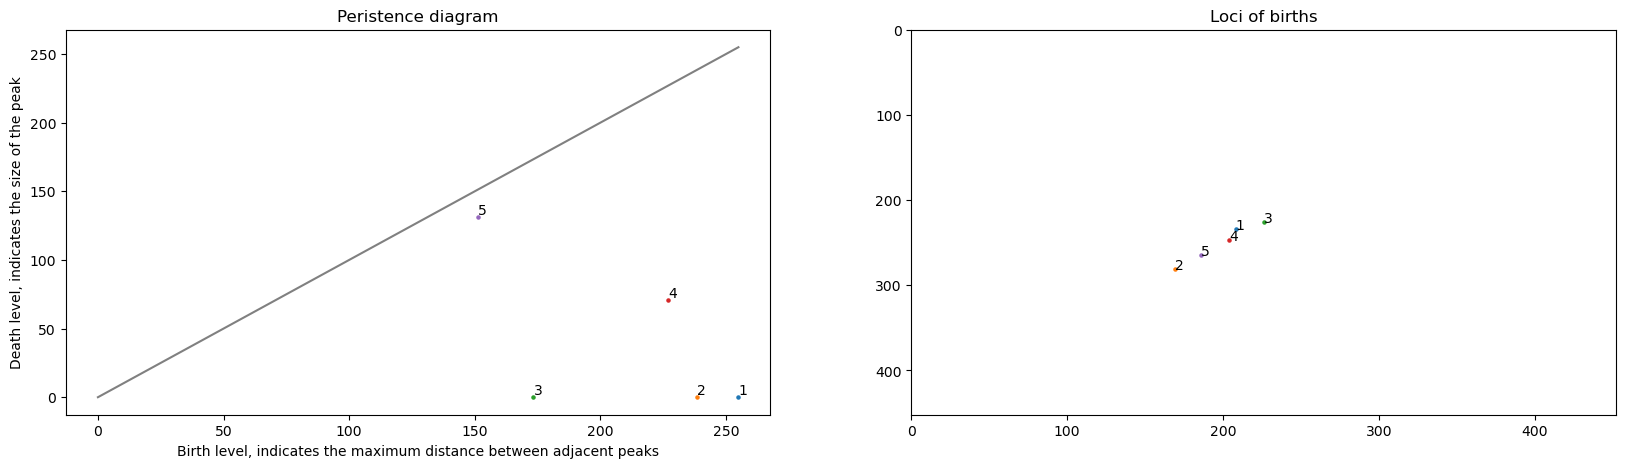

In [4]:
%matplotlib inline

x_coord, y_coord = [], []

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax.set_title("Peristence diagram")
ax.plot([0,255], [0,255], c='grey')
for i, homclass in enumerate(g0):
    p_birth, bl, pers, p_death = homclass
    print(f'p_birth: {p_birth}, bl (birth lvl): {bl}, pers: {pers}, death lvl: {bl-pers}, p_death: {p_death}')
    if pers <= 20:
        continue
    
    x, y = bl, bl-pers
    ax.scatter(x, y, s=5)
    ax.text(x, y+2, str(i+1))
ax.set_xlabel("Birth level, indicates the maximum distance between adjacent peaks")
ax.set_ylabel("Death level, indicates the size of the peak")
# ax.set_xlim((-5,260))
# ax.set_ylim((-5,260))


ax2.set_title("Loci of births")
for i, homclass in enumerate(g0):
    p_birth, bl, pers, p_death = homclass
    if pers <= 20:
        continue
    
    y, x = p_birth
    
    x_coord.append(x)
    y_coord.append(y)
    ax2.scatter(x, y, s=5)
    ax2.text(x, y+0.5, str(i+1))
    
ax2.set_xlim((0, im.shape[1]))
ax2.set_ylim((0, im.shape[0]))
ax2 = plt.gca()
plt.gca().invert_yaxis()

print('x:', x_coord)
print('y:', y_coord)

[102378 105976 108685 109587 111848 113656 115914 116804 119739 127406]
(array([226, 234, 240, 242, 247, 251, 256, 258, 264, 281], dtype=int64), array([226, 208, 205, 203, 204, 204, 202, 188, 411, 394], dtype=int64))
[1557.73453774 2956.89861954  236.00455132 1187.01224008 3257.06472557
 1820.79774382  389.65761423  222.34801115 2408.30667402 7054.79787231]


C:\Users\miron\AppData\Local\Temp\ipykernel_1692\3662742749.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_value = np.array(list(peak_value.items()))[0][1]
C:\Users\miron\AppData\Local\Temp\ipykernel_1692\3662742749.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peak_value2 = np.array(list(peak_value2.items()))[0][1]


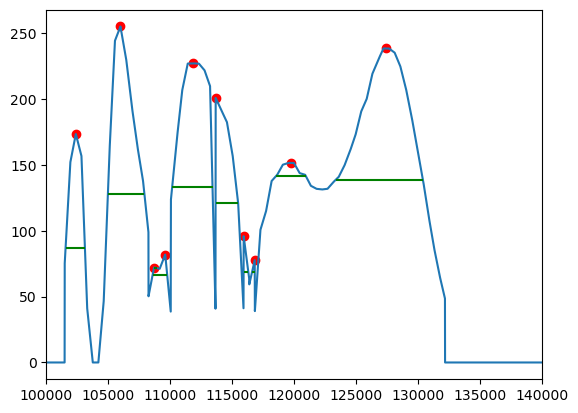

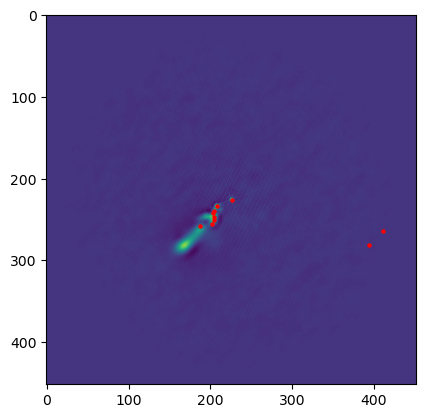

In [378]:
from scipy import interpolate
im2 = np.loadtxt("D:/astro/domecam/data/20210130l_m2km_corr_4.gz")

peak_coord, peak_value = find_peaks(im.ravel(), height=0)
peak_value = np.array(list(peak_value.items()))[0][1]

border_value = im.shape[0] + 5
border = np.where(np.diff(peak_coord) > border_value)[0][0]

arr2 = []
for i in range(np.diff(peak_coord)[border]//border_value):
    arr2.append(peak_coord[border] + (i+1)*border_value)

new_peak_coord = np.concatenate([peak_coord[0:border+1], arr2, peak_coord[border+1:]], axis=0)
new_peak_value = np.concatenate([peak_value[0:border+1], np.zeros_like((arr2,))[0], peak_value[border+1:]], axis=0)

x = np.linspace(new_peak_coord[0], new_peak_coord[-1], new_peak_coord[-1]-new_peak_coord[0])
interp = interpolate.interp1d(new_peak_coord, new_peak_value, kind = "linear") 
y_nearest = interp(x)
y2 = np.pad(y_nearest, (new_peak_coord[0], len(im.ravel())-new_peak_coord[-1]), 'constant', constant_values=(0))

peak_coord2, peak_value2 = find_peaks(y2, height=0)
peak_value2 = np.array(list(peak_value2.items()))[0][1]
print(peak_coord2)

print(np.unravel_index(peak_coord2, im.shape))

# yy=[226, 234, 282, 248, 264]
# xx=[226, 208, 169, 204, 186]
# converated_peaks = [(yy[i] * 452) + xx[i] for i in range(len(yy))] # перевод найденных 2d координат пиков в 1d 
goals = peak_widths(y2, peak_coord2, rel_height=0.5) # полуширина найденных пиков
print(goals[0])    

plt.figure()
# plt.plot(im.ravel())
# plt.scatter(new_peak_coord, new_peak_value, color='red')
plt.scatter(peak_coord2, peak_value2, c='red')
plt.plot(y2)
plt.hlines(*goals[1:], color='green')
plt.xlim((100000,140000))


plt.figure()
plt.imshow(im2)
plt.scatter(np.unravel_index(peak_coord2, im.shape)[1], np.unravel_index(peak_coord2, im.shape)[0], color='red', s=5)

C:\Users\miron\AppData\Local\Temp\ipykernel_1692\185953652.py:29: PeakPropertyWarning: some peaks have a prominence of 0
  metki = [peak_widths(gammas[i].ravel(), [np.argmax(gammas[i])], rel_height=width_value)[0]
C:\Users\miron\AppData\Local\Temp\ipykernel_1692\185953652.py:29: PeakPropertyWarning: some peaks have a width of 0
  metki = [peak_widths(gammas[i].ravel(), [np.argmax(gammas[i])], rel_height=width_value)[0]


1: Vy = 0.00, Vx = 0.00, Cn2 = 1.229211900351766e-13, z = 2525
2: Vy = -2.21, Vx = -4.98, Cn2 = 8.004430051118839e-14, z = 5051
3: Vy = -15.49, Vx = -15.76, Cn2 = 2.431426081832639e-14, z = 50000
4: Vy = -6.08, Vx = -6.08, Cn2 = 1.088787505261862e-14, z = 50000
5: Vy = -10.51, Vx = -11.06, Cn2 = 1.2841949877681222e-14, z = 40404

total Cn2: 2.510095762949913e-13
r0: 2.92
seeing: 0.35


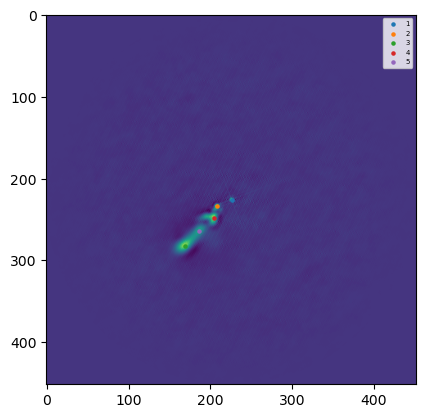

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

gammas = np.load("D:/astro/domecam/gammas_orig.npy")
a1 = np.loadtxt(f'D:/astro/domecam/z.gz')
cjk = np.loadtxt(f'D:/astro/domecam/cjk.gz')
im2 = np.loadtxt("D:/astro/domecam/data/20210130l_m2km_corr_4.gz")
delta = 2.5/(im2.shape[0]//2)
t = 0.01 * 4
# -----------------------------
y=[226, 234, 282, 248, 264]
x=[226, 208, 169, 204, 186]

width_value = 0.5
converated_peaks = [(y[i] * 452) + x[i] for i in range(len(y))] # перевод найденных 2d координат пиков в 1d 
goals = peak_widths(im.ravel(), converated_peaks, rel_height=width_value)[0] # полуширина найденных пиков
metki = [peak_widths(gammas[i].ravel(), [np.argmax(gammas[i])], rel_height=width_value)[0] 
         for i in range(gammas.shape[0])] # разметка
# заготовленной библиотеки гамм, полуширина пиков

plt.figure()
plt.imshow(im2)
total_Cn2=[]
initial_params=[]
for i in range(len(y)):
    Vy = (im2.shape[0]//2-y[i])*delta/t
    Vx = -(im2.shape[1]//2-x[i])*delta/t
    Cn2 = (im2[y[i], x[i]]/(cjk[y[i], x[i]] * np.max(gammas[find_nearest(metki, goals[i])])))
    z = a1[find_nearest(metki, goals[i])] / 1000
    total_Cn2.append(Cn2)
    layer = [Vx, Vy, Cn2, z]
    initial_params.append(layer)
    plt.scatter(x[i], y[i], s=5, label=f'{i+1}')
    print(f'{i+1}: Vy = {Vy:.2f}, Vx = {Vx:.2f}, Cn2 = {Cn2*1e-13}, z = {z*1000:.0f}')
plt.legend(prop = { "size": 5})

total_Cn2 = np.sum(total_Cn2)*1e-13
seeing_lambda = 500*10e-9
r0 = pow(0.423 * pow((2*np.pi/seeing_lambda), 2) * total_Cn2, -3/5)
seeing = 206265 * 0.98 * seeing_lambda/r0

print('\ntotal Cn2:', np.sum(total_Cn2))
print(f'r0: {r0:.2f}')
print(f'seeing: {seeing:.2f}')
# k=100
# plt.xlim(226-k,226+k)
# plt.ylim(226-k,226+k)

In [ ]:
def find_nearest1(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] >= value: #поставил тут =
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx
        
def gamma_poly_se(X, Y, Vx, Vy, Cn2, z): 
    global cjk, t, a1, gammas, delta
    Cn2=Cn2*1e-13
    z=z*1000
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest1(a1, z)[1]
    uv = find_nearest1(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    
    res = shift(res, (-Ypix, Xpix), order=2)  

    res = res * cjk
    return res

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, 0, 0]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, np.inf]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

In [ ]:
params = [0.0, 0.0, 1.513028296385884, 2.0202], [-4.977, -2.212, 0.8004430051118839, 5.0505]
fit, popt = one_speckle_fit(params=initial_params, data=im2)
plt.imshow(fit)